In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, brier_score_loss, classification_report
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
ambulance_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Ambulance_final.csv')
road_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Road_final.csv')

Mounted at /content/gdrive


In [ ]:
ambulance_df = pd.read_csv('Ambulance_final.csv')
road_df = pd.read_csv('Road_final.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Ambulance_final.csv'

In [ ]:
road_df.columns = ambulance_df.columns
combined_df = pd.concat([ambulance_df, road_df], axis=0, ignore_index=True)
combined_df = combined_df.drop(combined_df.columns[0], axis=1)
X = combined_df.drop('label', axis=1)
y = combined_df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
combined_X_train = scaler.fit_transform(X_train)
combined_X_test = scaler.fit_transform(X_test)

In [ ]:
# Random Forest Classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)


y_pred = random_forest_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Ambulance')
recall = recall_score(y_test, y_pred, pos_label='Ambulance')
f1 = f1_score(y_test, y_pred, pos_label='Ambulance')


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

   Ambulance       0.96      0.97      0.97       187
        Road       0.97      0.96      0.96       180

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367



In [ ]:
# Random Parameter Searching
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20, 30],     # Maximum depth of the trees
    'min_samples_split': [2, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 4],               # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],         # Number of features considered for splitting
    'criterion': ['gini', 'entropy'],   # Function to measure the quality of a split
    'class_weight': [None, 'balanced']  # Adjust weights for imbalanced classes
}
pipe = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2)
pipe.fit(combined_X_train, y_train)
print(f"Best score", pipe.best_score_)
print(f"Best hyperparameters", pipe.best_params_)
print(f"Test score", pipe.score(combined_X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score 0.9638503865710106
Best hyperparameters {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy', 'class_weight': None}
Test score 0.9645776566757494


In [ ]:
# Grid Parameter Searching
param_grid = {
    'n_estimators': [250, 300, 350],        # Narrow around the best n_estimators (300)
    'max_depth': [25, 30, 35],             # Focus around the best max_depth (30)
    'min_samples_split': [2, 3, 5],        # Explore around the lower split value
    'min_samples_leaf': [1, 2],            # Keep low values for minimal overfitting
    'max_features': ['sqrt'],              # Keep the best option ('sqrt')
    'criterion': ['entropy'],              # Stick with the best criterion ('entropy')
    'class_weight': [None]                 # Use the best-performing class weight (None)
}
pipe = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
pipe.fit(combined_X_train, y_train)
print(f"Best score", pipe.best_score_)
print(f"Best hyperparameters", pipe.best_params_)
print(f"Test score", pipe.score(combined_X_test, y_test))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best score 0.9618026050010448
Best hyperparameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 250}
Test score 0.9645776566757494


In [ ]:
# Fine tuned hyperparameter
random_forest_model = RandomForestClassifier(
    class_weight=None,
    criterion='entropy',
    max_depth=25,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=250
)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Ambulance')
recall = recall_score(y_test, y_pred, pos_label='Ambulance')
f1 = f1_score(y_test, y_pred, pos_label='Ambulance')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Ambulance       0.96      0.97      0.97       187
        Road       0.97      0.96      0.96       180

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367



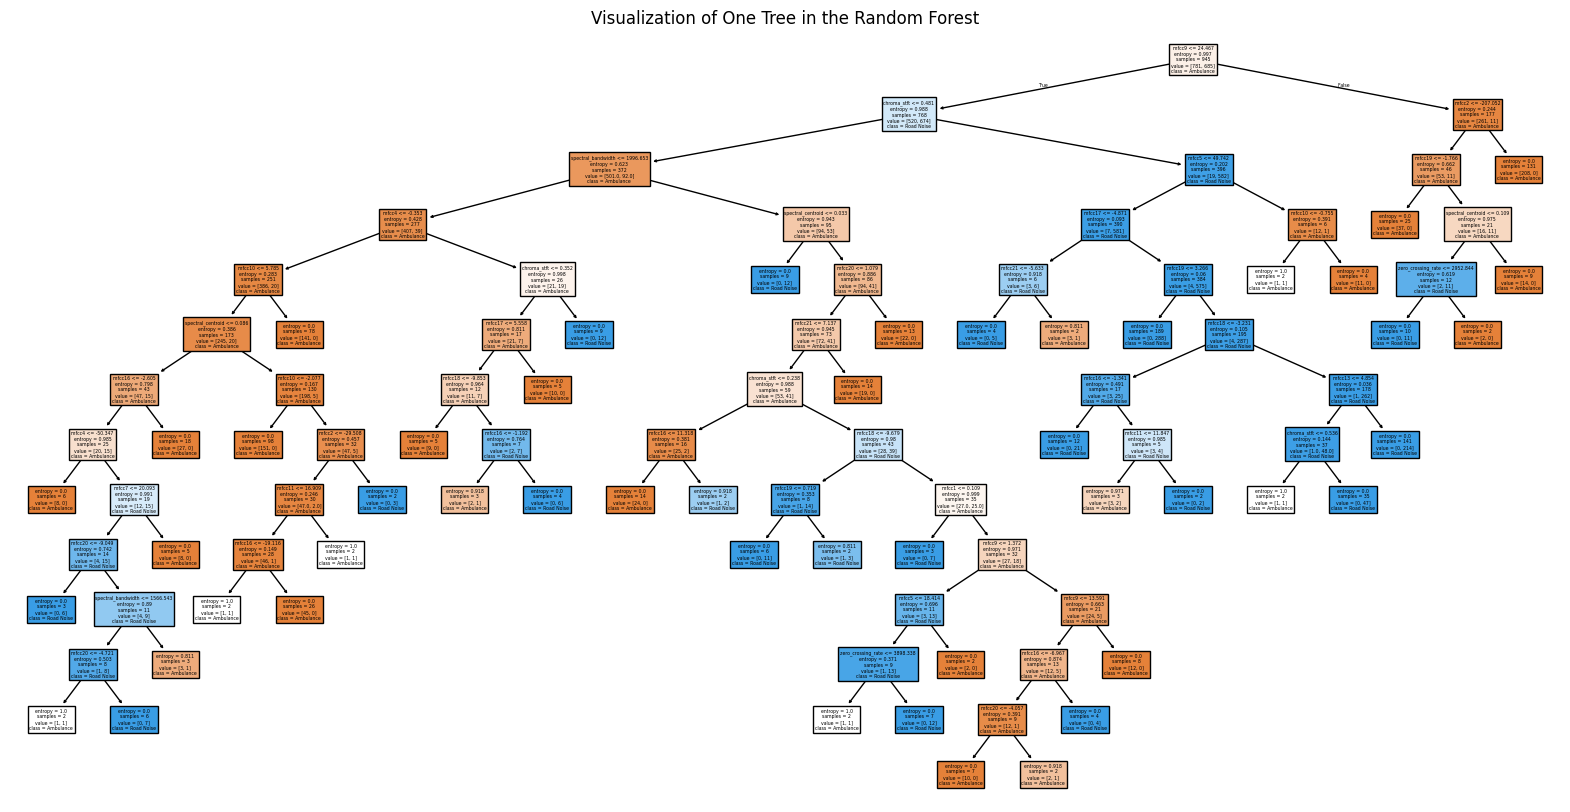

In [ ]:
# Plot of a single tree within the Random Forest
single_tree = random_forest_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(single_tree,
          filled=True,
          feature_names=X_train.columns,
          class_names=['Ambulance', 'Road Noise'])
plt.title("Visualization of One Tree in the Random Forest")
plt.show()

In [ ]:
# from homework 2, feature importances:
feature_names = combined_df.columns
feat_importances = zip(feature_names, random_forest_model.feature_importances_)
feats, importances = zip(*(sorted(list(filter(lambda x: [1] != 0, feat_importances)), key=lambda x: x[1], reverse=True)))

list_feats = list(feats)
list_importances = list(importances)

top_feats = list_feats[:5]
top_importances = list_importances[:5]

print("Top three features: " + str(top_feats))

# random forest model provides interprebility

Top three features: ['chroma_stft', 'spectral_centroid', 'rolloff', 'mfcc8', 'mfcc1']


<ipython-input-16-f03e0b74179b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


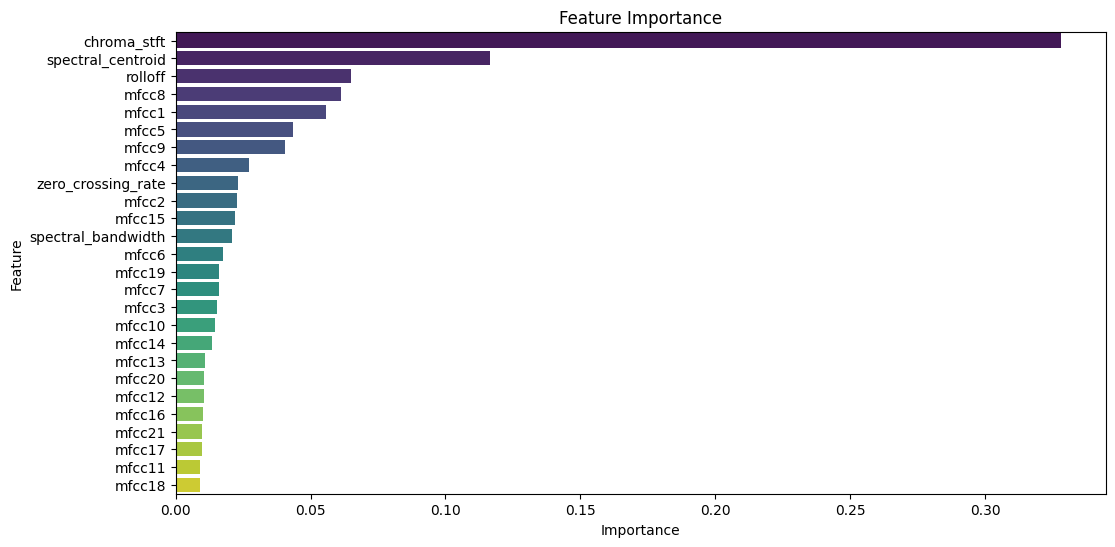

In [ ]:
# Visualizing the feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': random_forest_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance')
plt.show()

Here "road" is the default label and "ambulance" is the positive class.

In [ ]:
# from hw1
primal = LinearSVC(dual=False)
primal.fit(combined_X_train, y_train)

y_pred_train = primal.predict(combined_X_train)
print(f"Training Accuracy: {accuracy_score(y_train,y_pred_train) * 100:.2f}%")

y_pred_test = primal.predict(combined_X_test)
print(f"Test Accuracy: {accuracy_score(y_test,y_pred_test) * 100:.2f}%")

print(classification_report(y_test, y_pred_test))

Training Accuracy: 95.02%
Test Accuracy: 94.01%
              precision    recall  f1-score   support

   Ambulance       0.94      0.94      0.94       187
        Road       0.94      0.94      0.94       180

    accuracy                           0.94       367
   macro avg       0.94      0.94      0.94       367
weighted avg       0.94      0.94      0.94       367



In [ ]:
dual = LinearSVC(dual=True)
dual.fit(combined_X_train, y_train)

y_pred_train = dual.predict(combined_X_train)
print(f"Training Accuracy: {accuracy_score(y_train,y_pred_train) * 100:.2f}%")

y_pred_test = dual.predict(combined_X_test)
print(f"Test Accuracy: {accuracy_score(y_test,y_pred_test) * 100:.2f}%")

print(classification_report(y_test, y_pred_test))

Training Accuracy: 95.02%
Test Accuracy: 94.01%
              precision    recall  f1-score   support

   Ambulance       0.94      0.94      0.94       187
        Road       0.94      0.94      0.94       180

    accuracy                           0.94       367
   macro avg       0.94      0.94      0.94       367
weighted avg       0.94      0.94      0.94       367

